In [40]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

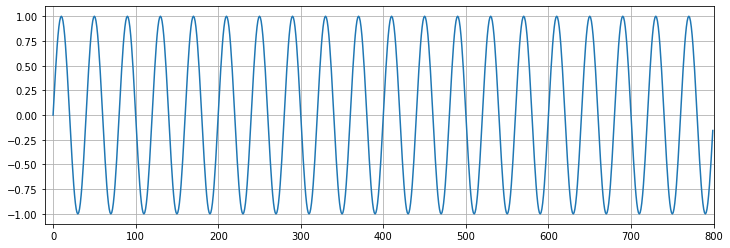

In [41]:
## create a sine wave

x = torch.linspace(0,799,steps=800)
y = torch.sin(x*2*3.1416/40)

plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(X,y)
plt.show()

In [42]:
## create train and test data

test_size = 40

train_set = y[:-test_size]
test_set = y[-test_size:]

In [43]:
def input_size(seq, ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        
        out.append((window, label))
    return out

In [44]:
window_size = 40
train_data = input_size(train_set, window_size)
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

In [45]:
train_data[1]

(tensor([ 1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,  7.0711e-01,
          8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,  1.0000e+00,
          9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,  7.0710e-01,
          5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01, -7.2400e-06,
         -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01, -7.0711e-01,
         -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01, -1.0000e+00,
         -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01, -7.0710e-01,
         -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01,  1.4480e-05]),
 tensor([0.1564]))

## Define LSTM

In [46]:
class LSTMModel(nn.Module):
    
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size,hidden_size)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.hidden = (torch.zeros(1,1,hidden_size), torch.zeros(1,1,hidden_size)) # intialise h0 and c0
        
        
    def forward(self,x):
        lstm_out, self.hidden = self.lstm(x.view(len(x),1,-1), self.hidden)
        pred = self.fc1(lstm_out.view(len(x),-1))
        
        return pred[-1]  # only returning the last prediction
        

In [47]:
model = LSTMModel()
model

LSTMModel(
  (lstm): LSTM(1, 50)
  (fc1): Linear(in_features=50, out_features=1, bias=True)
)

In [48]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [49]:
params = [p.numel() for p in model.parameters() if p.requires_grad]
print(f'{params}')
print(f'Total Params: {sum(params)}')

[200, 10000, 200, 200, 50, 1]
Total Params: 10651


Epoch:0 	 Loss:0.08648735
Loss on test predictions: 0.6075307130813599


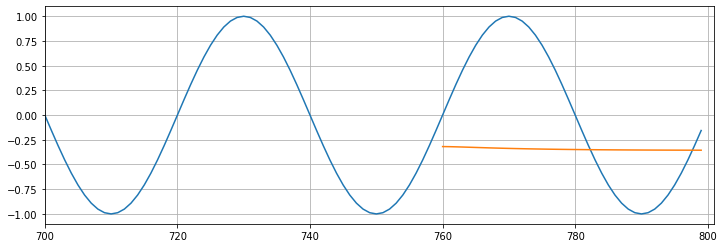

Epoch:1 	 Loss:0.05953511
Loss on test predictions: 0.5610097646713257


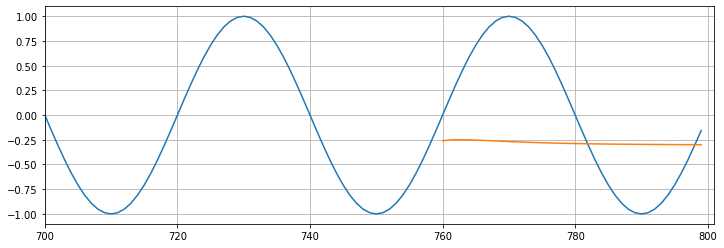

Epoch:2 	 Loss:0.03146734
Loss on test predictions: 0.4865446090698242


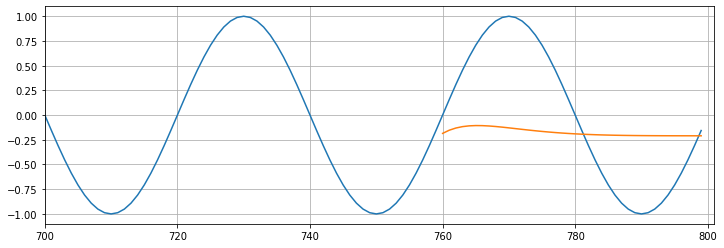

Epoch:3 	 Loss:0.00673349
Loss on test predictions: 0.2721485197544098


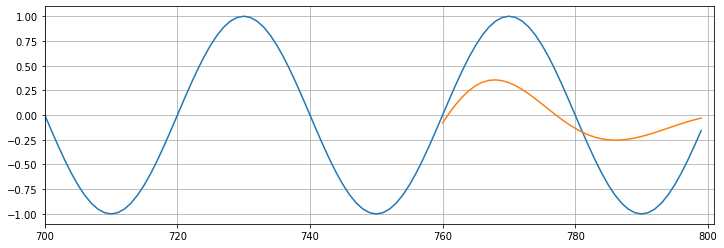

Epoch:4 	 Loss:0.00062785
Loss on test predictions: 0.026179710403084755


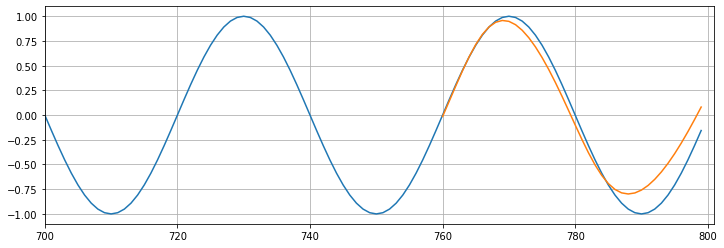

Epoch:5 	 Loss:0.00020161
Loss on test predictions: 0.005834386684000492


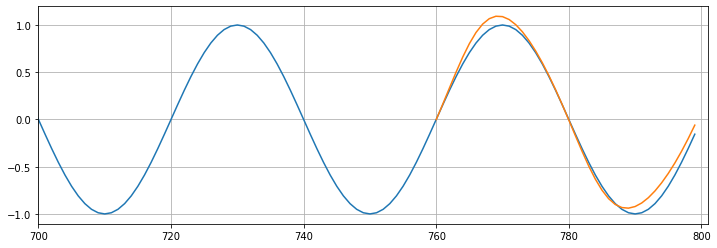

Epoch:6 	 Loss:0.00015297
Loss on test predictions: 0.004845533519983292


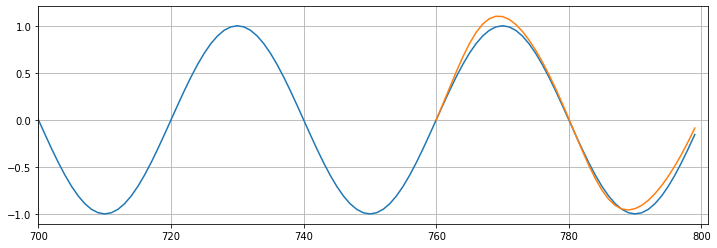

Epoch:7 	 Loss:0.00013428
Loss on test predictions: 0.0042945160530507565


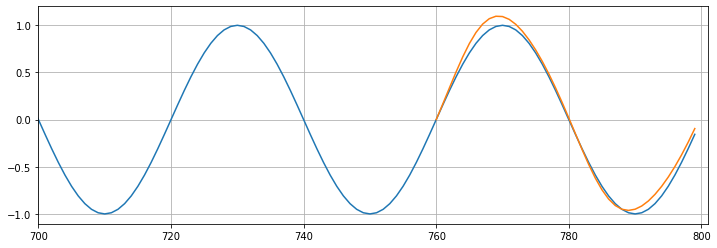

Epoch:8 	 Loss:0.00012020
Loss on test predictions: 0.003845141502097249


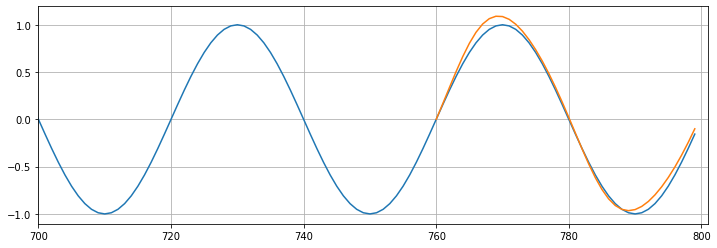

Epoch:9 	 Loss:0.00010816
Loss on test predictions: 0.0034723379649221897


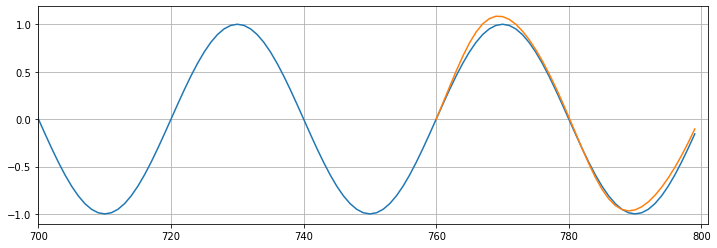

In [50]:
### training the model

epochs = 10
future = 40

for i in range(epochs):
    
    for X_train, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1, model.hidden_size))
        
        y_pred = model(X_train)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{i} \t Loss:{loss.item():10.8f}')
    
    preds = train_set[-window_size:].tolist()

    for f in range(future):  
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            preds.append(model(seq).item())
            
    loss = criterion(torch.tensor(preds[-window_size:]),y[760:])
    print(f'Loss on test predictions: {loss}')

    # Plot from point 700 to the end
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800),preds[window_size:])
    plt.show()

# Forecasting into the future

In [52]:
epochs = 10
window_size = 40
future = 40

# Create the full set of sequence/label tuples:
all_data = input_size(y,window_size)
len(all_data)

760

In [53]:
import time
start_time = time.time()

for i in range(epochs):
    
    for seq, y_train in all_data:  
       
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00009715
Epoch:  2 Loss: 0.00008764
Epoch:  3 Loss: 0.00007940
Epoch:  4 Loss: 0.00007222
Epoch:  5 Loss: 0.00006596
Epoch:  6 Loss: 0.00006049
Epoch:  7 Loss: 0.00005569
Epoch:  8 Loss: 0.00005147
Epoch:  9 Loss: 0.00004775
Epoch: 10 Loss: 0.00004446

Duration: 62 seconds


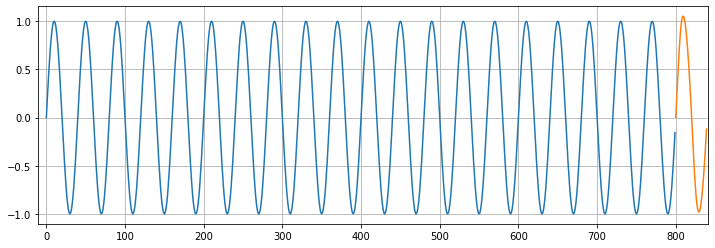

In [55]:
preds = y[-window_size:].tolist()

for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

plt.figure(figsize=(12,4))
plt.xlim(-10,841)
plt.grid(True)
plt.plot(y.numpy())
plt.plot(range(800,800+future),preds[window_size:])
plt.show()